<a href="https://colab.research.google.com/github/mr2980/Gravitational-Wave-Detection/blob/main/GWD_AliSalman_MatthewRosencrans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitation Wave Detection 


CNN Architecture

### Collaborators:
Matthew Rosencrans, Ali Salman

--------------------

## Prepare Data

In [ ]:
import numpy as np
import torch
from google.colab import drive
drive.mount('/content/drive/')
import h5py 
valid = h5py.File('/content/drive/My Drive/CCSN_Pan_SNR_Free_Test_Validation.h5','r')

Mounted at /content/drive/


In [ ]:
free = h5py.File('/content/drive/My Drive/CCSN_Pan_SNR_Free.h5','r') 

In [ ]:
signal_nr = free['Model_NR']['Hp']
signal_sr = free['Model_SR']['Hp']
signal_fr = free['Model_FR']['Hp']
noise = free['Noise']['Strain']

In [ ]:
# Import the desired amount of data and create targets list
noise_import = 10800
signal_import = 3600
zeros = np.zeros(noise_import)
ones = np.ones(3*signal_import)
targets = np.hstack((zeros,ones))
print(targets.shape)

(21600,)


In [ ]:
# Create trining data
import numpy as np
noise_np = np.array(noise[0:noise_import])
signal_nr_np = np.array(signal_nr[0:signal_import])
signal_sr_np = np.array(signal_sr[0:signal_import])
signal_fr_np = np.array(signal_fr[0:signal_import])

noise_signal = np.vstack((noise_np,signal_nr_np,signal_sr_np,signal_fr_np))

In [ ]:
# Check sizes
print(signal_nr_np.shape)
print(noise_np.shape)
print(signal_sr_np.shape)
print(signal_fr_np.shape)

(3600, 8192)
(10800, 8192)
(3600, 8192)
(3600, 8192)


In [ ]:
# Split in into training and validation sets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
noise_train, noise_valid, target_train, target_valid= train_test_split(noise_signal,targets,train_size = 0.9, test_size = 0.1, random_state = True)


In [ ]:
# Standard Scaling
noise_train = scaler.fit_transform(noise_train)
noise_valid = scaler.fit_transform(noise_valid)
print(noise_train)
print(noise_valid.shape)
print(target_train.shape)
print(target_valid.shape)

[[-1.0165807  -0.71419202 -0.7140877  ... -0.37492578 -0.38815545
   1.85495349]
 [ 2.42675197 -0.10610247 -0.29461901 ... -1.22342321 -1.45445159
  -0.1713078 ]
 [ 0.22077676 -0.40158274 -0.67880729 ...  1.74479434  1.77372344
   0.31605129]
 ...
 [ 0.37723769 -1.25336317 -1.44251144 ...  0.11567512 -0.18982957
  -0.13924416]
 [ 0.55931279 -1.73527858 -1.62925384 ...  0.81714839  1.27685326
   0.80709389]
 [-1.00974573  0.98723104  1.40337294 ... -1.38840215 -1.31993177
   0.91194934]]
(2160, 8192)
(19440,)
(2160,)


In [ ]:
#(N,channels,length)
noise_train = np.reshape(noise_train,((19440, 1, 8192)))
noise_valid = np.reshape(noise_valid,((2160, 1, 8192)))


## Define Model

In [ ]:
# class represents CNN model for gravity wave classification 
class CNNModel(torch.nn.Module):
    # used three convolutional layers along with three max pool layers. The dimensions are preserved through each 
    # convolutional layer but reduced through the maxpool layers. The number of channels are doubled through each maxpool 
    # layer starting with 1 channel to 16.
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        
        # First convolution layer (1 channel -> 16 channels, preserve original dimension by adding padding = 2)
        self.cnn1 = torch.nn.Conv1d(in_channels=1, out_channels=16, 
                              kernel_size=20, stride=1, padding=2)
        
        # First max pooling layer with kernel size = 2
        self.maxpool1 = torch.nn.MaxPool1d(kernel_size=2)
         
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.cnn2 = torch.nn.Conv1d(in_channels=16, out_channels=32, 
                              kernel_size=20, stride=1, padding=2)
        
        # Second max pooling layer with kernel size = 2
        self.maxpool2 = torch.nn.MaxPool1d(kernel_size=2)
        
        # Second convolution layer (32 channel -> 64 channels, preserve dimension by adding padding = 2)
        self.cnn3 = torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=25, stride=1, padding=2)
        self.maxpool3 = torch.nn.MaxPool1d(kernel_size=2)
        
        self.dropout = torch.nn.Dropout(p=0.1)

        self.fc1 = torch.nn.Linear(64512, 1000)
        self.fc2 = torch.nn.Linear(1000, 2)
        
    # feed forward function takes output from each layer and feeds it into next layer    
    def forward(self, x):
        
        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))       
        pool1_out = self.maxpool1(conv1_out)
        
        # maxpool1 output -> conv2 -> relu -> maxpool2
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))    
        pool2_out = self.maxpool2(conv2_out)
        
        # maxpool2 output -> conv3 -> relu -> maxpool3
        conv3_out = torch.nn.functional.relu(self.cnn3(pool2_out))
        pool3_out = self.maxpool3(conv3_out)
        
        # flatten the maxpool2 output to be used as input into FCN layer
        fcn_input = pool3_out.view(pool3_out.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        output = self.fc1(fcn_input)
        output = self.dropout(output)
        output = self.fc2(output)

        
        return output

## Define Hyperparameters

In [ ]:
torch.manual_seed(1)
cnnModel = CNNModel()

learning_rate = 0.0003
epochs = 20
batchsize = 250 #data is split into batches 

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnnModel.parameters(), lr = learning_rate)

cnnModel.cuda()

CNNModel(
  (cnn1): Conv1d(1, 16, kernel_size=(20,), stride=(1,), padding=(2,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv1d(16, 32, kernel_size=(20,), stride=(1,), padding=(2,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv1d(32, 64, kernel_size=(25,), stride=(1,), padding=(2,))
  (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64512, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=2, bias=True)
)

## Identify Tracked Values

In [ ]:
train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [ ]:
#convert data to torch arrays
import tqdm
noise_train = torch.from_numpy(noise_train).float().cuda()
target_train = torch.from_numpy(target_train).long().cuda()

noise_valid = torch.from_numpy(noise_valid).float().cuda()
target_valid = torch.from_numpy(target_valid).long().cuda()

noise_train_batches = torch.split(noise_train, batchsize)
target_train_batches = torch.split(target_train, batchsize)


batch_split_num = len(noise_train_batches)

# Training Loop ---------------------------------------------------------------------------------------
# where the model training will take place 
# will keep track of the training loss every epoch
# for each epoch, compute according to batch size
for epoch in tqdm.trange(epochs):
    for k in range(batch_split_num):

        optimizer.zero_grad()

        train_batch_outputs = cnnModel(noise_train_batches[k])

        loss = loss_func(train_batch_outputs, target_train_batches[k])

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------
    # keep track of validation accuracy for later
    with torch.no_grad():

        validation_outputs = cnnModel(noise_valid)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   target_valid).type(torch.FloatTensor)
        
        #print("validation output: " , validation_outputs.shape)
        #print("target valid ", target_valid.shape)
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list[epoch] = correct.mean()
      
    print("Average Training Loss: " + str(np.mean(train_loss_list[-batch_split_num:])))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 Validation Accuracy: 49.35%


  5%|▌         | 1/20 [00:19<06:04, 19.19s/it]

Average Training Loss: 1.1004927188922198
Epoch: 1 Validation Accuracy: 83.29%


 10%|█         | 2/20 [00:37<05:40, 18.94s/it]

Average Training Loss: 0.5102100815528479
Epoch: 2 Validation Accuracy: 85.46%


 15%|█▌        | 3/20 [00:57<05:23, 19.05s/it]

Average Training Loss: 0.35027967202357757
Epoch: 3 Validation Accuracy: 84.91%


 20%|██        | 4/20 [01:16<05:08, 19.25s/it]

Average Training Loss: 0.3339983005172167
Epoch: 4 Validation Accuracy: 85.65%


 25%|██▌       | 5/20 [01:36<04:53, 19.59s/it]

Average Training Loss: 0.3247730844678023
Epoch: 5 Validation Accuracy: 86.9%


 30%|███       | 6/20 [01:57<04:37, 19.84s/it]

Average Training Loss: 0.3163441255306586
Epoch: 6 Validation Accuracy: 87.08%


 35%|███▌      | 7/20 [02:17<04:18, 19.85s/it]

Average Training Loss: 0.3100752727343486
Epoch: 7 Validation Accuracy: 87.36%


 40%|████      | 8/20 [02:36<03:58, 19.84s/it]

Average Training Loss: 0.30006060825708586
Epoch: 8 Validation Accuracy: 87.5%


 45%|████▌     | 9/20 [02:56<03:38, 19.90s/it]

Average Training Loss: 0.2939754267915701
Epoch: 9 Validation Accuracy: 87.55%


 50%|█████     | 10/20 [03:17<03:19, 19.95s/it]

Average Training Loss: 0.2861218519317798
Epoch: 10 Validation Accuracy: 88.15%


 55%|█████▌    | 11/20 [03:37<02:59, 19.99s/it]

Average Training Loss: 0.2775120714153999
Epoch: 11 Validation Accuracy: 88.56%


 60%|██████    | 12/20 [03:56<02:39, 19.97s/it]

Average Training Loss: 0.2683446726355797
Epoch: 12 Validation Accuracy: 88.75%


 65%|██████▌   | 13/20 [04:17<02:19, 19.99s/it]

Average Training Loss: 0.26103364332364154
Epoch: 13 Validation Accuracy: 88.19%


 70%|███████   | 14/20 [04:37<02:00, 20.01s/it]

Average Training Loss: 0.2588300089805554
Epoch: 14 Validation Accuracy: 88.94%


 75%|███████▌  | 15/20 [04:57<01:40, 20.02s/it]

Average Training Loss: 0.2431432782457425
Epoch: 15 Validation Accuracy: 89.26%


 80%|████████  | 16/20 [05:17<01:20, 20.02s/it]

Average Training Loss: 0.22794343263675004
Epoch: 16 Validation Accuracy: 89.17%


 85%|████████▌ | 17/20 [05:37<01:00, 20.00s/it]

Average Training Loss: 0.2164525683873739
Epoch: 17 Validation Accuracy: 88.24%


 90%|█████████ | 18/20 [05:57<00:40, 20.01s/it]

Average Training Loss: 0.20676316951329893
Epoch: 18 Validation Accuracy: 88.56%


 95%|█████████▌| 19/20 [06:17<00:20, 20.02s/it]

Average Training Loss: 0.1963632175555596
Epoch: 19 Validation Accuracy: 88.19%


100%|██████████| 20/20 [06:37<00:00, 19.86s/it]

Average Training Loss: 0.19090487368595907


## Visualize & Evaluate Model

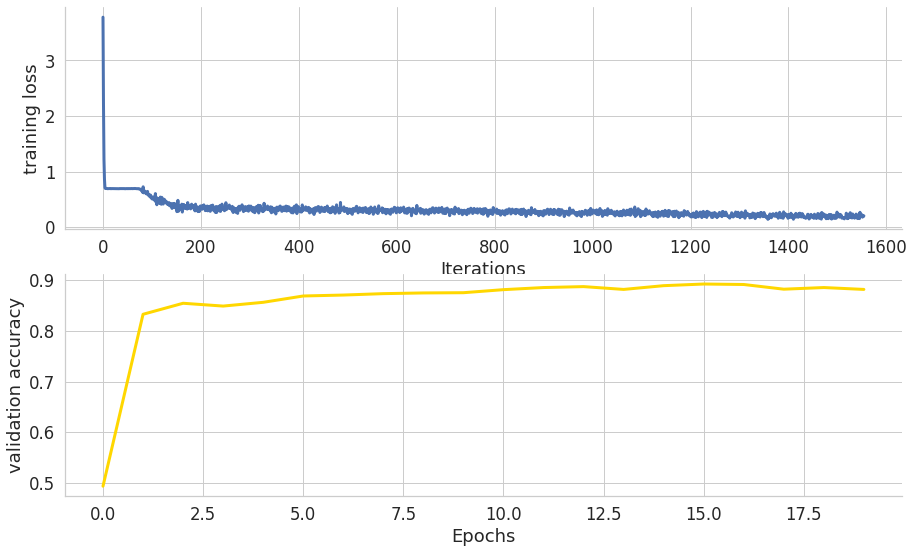

In [ ]:
# Plot Loss and Validation Accuracy
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 1.5)

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list[5:], linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("Iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.xlabel("Epochs")
sns.despine()

##Test Model


In [ ]:
# Import Testing Data
cnnModel.cpu()
signal_nr_test = valid['Model_NR']['Hp']
signal_sr_test = valid['Model_SR']['Hp']
signal_fr_test = valid['Model_FR']['Hp']
noise_test = valid['Noise']['Strain']

# Import subset of testing data
noise_test = np.array(noise_test[0:600])
signal_nr_test = np.array(signal_nr_test[0:200])
signal_sr_test = np.array(signal_sr_test[0:200])
signal_fr_test = np.array(signal_fr_test[0:200])

print(noise_test.shape)
print(signal_nr_test.shape)

# Create targets
zeros = np.zeros(600)
ones = np.ones(3*200)
targets_test = np.hstack((zeros,ones))
print(targets_test.shape)

nr_target = np.full((200,), 1)
sr_target = np.full((200,), 1)
fr_target = np.full((200,), 1)

noise_signal_test = np.vstack((noise_test,signal_nr_test,signal_sr_test,signal_fr_test))
noise_signal_test = scaler.fit_transform(noise_signal_test)
print(noise_signal_test.shape)
noise_signal_test = np.reshape(noise_signal_test,((1200, 1, 8192)))

noise_signal_test = torch.from_numpy(noise_signal_test).float()
targets_test = torch.from_numpy(targets_test).long()

# Test trained model
with torch.no_grad():
    
    pred_test = cnnModel(noise_signal_test)
     
    correct = (torch.argmax(pred_test, dim=1) == targets_test).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

(600, 8192)
(200, 8192)
(1200,)
(1200, 8192)
Testing Accuracy: 0.9058333


Noise Accuracy: 0.9733333333333334
Signal Accuracy: 0.8383333333333334
NR Accuracy: 0.835
SR Accuracy: 0.8
FR Accuracy: 0.88


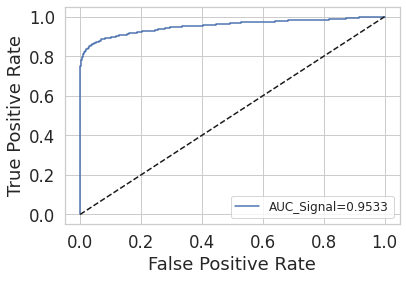

In [ ]:
# results are further split into strain types for classification and accuracy is computed for each
with torch.no_grad():
  noise_correct = np.array([])
  signal_correct = np.array([])
  nr_correct = np.array([])
  sr_correct = np.array([])
  fr_correct = np.array([])
  #600, 800, 1000

  # Noise
  for i in range(600):
    if correct[i] == 1:
      noise_correct = np.append(noise_correct, 1)
    else:
      noise_correct = np.append(noise_correct, 0)
  print("Noise Accuracy: " + str(noise_correct.mean()))

  # Signal
  for i in range(600):
    if targets_test[i+600] == correct[i+600]:
      signal_correct = np.append(signal_correct, 1)
    else:
      signal_correct = np.append(signal_correct, 0)
  print("Signal Accuracy: " + str(signal_correct.mean()))

  # No Rotation
  for i in range(200):
    if targets_test[i+600] == correct[i+600]:
      nr_correct = np.append(nr_correct, 1)
    else:
      nr_correct = np.append(nr_correct, 0)
  print("NR Accuracy: " + str(nr_correct.mean()))

  # Slow Rotation
  for i in range(200):
    if targets_test[i+800] == correct[i+800]:
      sr_correct = np.append(sr_correct, 1)
    else:
      sr_correct = np.append(sr_correct, 0)
  print("SR Accuracy: " + str(sr_correct.mean()))

  # Fast Rotation
  for i in range(200):
    if targets_test[i+1000] == correct[i+1000]:
      fr_correct = np.append(fr_correct, 1)
    else:
      fr_correct = np.append(fr_correct, 0)
  print("FR Accuracy: " + str(fr_correct.mean()))

  # Compute ROC values
  from sklearn import metrics
  fpr, tpr, _ = metrics.roc_curve(targets_test, pred_test[:,1] )
  auc = metrics.roc_auc_score(targets_test, pred_test[:,1] )
  from math import log10 , floor
  def round_it(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)
  auc = round_it(auc, 4)

  # Create ROC curve
  plt.plot(fpr,tpr, label="AUC_Signal="+str(auc))
  plt.plot([0, 1], [0, 1], "k--")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4, prop={'size': 12})
  plt.show()